In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


In [2]:
full_data = pd.read_csv("everything100percat.csv")


# vocab diversity computation from revised_pipeline.ipynb


In [5]:
def compute_vocab_diversity(text: str, window_size: int = 250):
    """Compute vocabulary diversity metrics"""
    if not isinstance(text, str) or not text.strip():
        return 0.0, 0.0

    tokens = text.split()[:window_size]
    unique_count = len(set(tokens))
    total_count = len(tokens) or 1

    # Normalized TTR = unique / sqrt(2 * total)
    nTTR = unique_count / ((2 * total_count) ** 0.5)

    # Word-density: lines = count of '\n' + 1, avg_line_len:
    lines = text.count("\n") + 1
    avg_line_len = sum(len(line) for line in text.split("\n")) / lines
    wd = 100 * unique_count / (lines * (avg_line_len or 1))

    return nTTR, wd


In [6]:
from python_code import parallel

# Compute vocabulary diversity in parallel
all_revs = parallel.process_dataframe_parallel(
    full_data,
    compute_vocab_diversity,
    column="plain_text",
    new_column=["nTTR", "word_density"],
    use_threads=True  # This is lightweight
)


Processing 15832 items with 4 workers


Processing plain_text:   0%|          | 0/15832 [00:00<?, ?it/s]

In [9]:
 all_revs

,Unnamed: 0,snapshot_ts,rev_id,timestamp,user,is_bot,content,article_id,title,root,...,clause_ratio,voice_ratio,fre,fog,chars_per_sent,sents_per_para,nTTR,word_density,avg_line_len,citation_delta
0,0,2023-06-30 00:00:00+00:00,1160763005,2023-06-18 16:30:41+00:00,2601:483:C301:7360:BC05:287F:176:F15F,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,0.280000,1.000000,-55.581724,53.007301,350.360000,25.0,6.529318,1.662302,8783.0,0.002269
1,1,2023-07-31 00:00:00+00:00,1166013433,2023-07-18 21:17:52+00:00,TompaDompa,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,0.230769,1.000000,-54.688918,52.586390,334.269231,26.0,6.574040,1.686553,8716.0,0.002288
2,2,2023-08-31 00:00:00+00:00,1171485250,2023-08-21 11:13:21+00:00,79.41.96.200,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,0.230769,1.000000,-55.556147,52.945779,336.653846,26.0,6.574040,1.674641,8778.0,0.002270
3,3,2023-09-30 00:00:00+00:00,1177319025,2023-09-27 04:45:15+00:00,187.254.98.237,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,0.280000,1.000000,-55.224708,52.867424,350.240000,25.0,6.574040,1.674260,8780.0,0.002817
4,4,2023-10-31 00:00:00+00:00,1181899435,2023-10-25 22:06:39+00:00,Idulatria,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,0.269231,1.000000,-55.502305,52.973933,336.730769,26.0,6.574040,1.674260,8780.0,0.002817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15827,15827,2023-12-31 00:00:00+00:00,1190712502,2023-12-19 11:44:12+00:00,Mika1h,False,{{more citations needed|date=April 2023}}\n{{I...,8654,Pac-Man All-Stars,Video games,...,0.571429,0.997159,34.591492,14.235897,126.071429,14.0,7.812831,9.802817,1775.0,0.020779
15828,15828,2024-01-31 00:00:00+00:00,1197552616,2024-01-21 00:52:22+00:00,Venky64,False,{{more citations needed|date=April 2023}}\n{{I...,8654,Pac-Man All-Stars,Video games,...,0.500000,0.997118,34.471790,14.223013,124.500000,14.0,7.650271,9.640616,1753.0,0.020725
15829,15829,2023-08-31 00:00:00+00:00,1172064757,2023-08-24 18:34:01+00:00,CurlyWi,False,{{Infobox video game\n| collapsible = \n| ital...,10527,Idol Showdown,Video games,...,0.777778,0.983655,38.320567,13.139394,137.814815,27.0,6.842368,4.083267,3747.0,0.015666
15830,15830,2023-10-31 00:00:00+00:00,1181427482,2023-10-23 00:04:28+00:00,Radja Dwm,False,{{Infobox video game\n| collapsible = \n| ital...,10527,Idol Showdown,Video games,...,0.666667,0.985714,36.978658,13.724887,141.166667,30.0,6.976532,3.658537,4264.0,0.013761


In [11]:
# Assuming 'df' is your full feature DataFrame and it has a 'clean_text' column
# 1. Calculate token count for each revision
# Replace NaN values with an empty string, then apply the split.
# This is the most robust and idiomatic way to handle this in pandas.
all_revs['token_count'] = all_revs['plain_text'].fillna('').apply(lambda x: len(x.split()))
# 2. Create a stratified sample (e.g., 200 revisions from each root category)
# This ensures your sample represents all topics.
sample_df = all_revs.groupby('root').sample(n=200, random_state=42, replace=True)
print(f"Created a sample of {len(sample_df)} revisions for analysis.")

Created a sample of 4000 revisions for analysis.


In [13]:

window_sizes_to_test = [100, 250, 500, 750, 1000]

for window in window_sizes_to_test:
    col_name = f'nTTR_{window}'
    print(f"Calculating {col_name}...")
    # You'll need to adapt this line to how your nTTR function is called
    sample_df[col_name] = sample_df['plain_text'].apply(
        lambda text: compute_vocab_diversity(text, window_size=window)
    )

Calculating nTTR_100...
Calculating nTTR_250...
Calculating nTTR_500...
Calculating nTTR_750...
Calculating nTTR_1000...


In [15]:
import pandas as pd

# Define a robust wrapper function to handle the output of calculate_nttr
def get_nttr_score(text, window_size):
    """
    A wrapper to safely call the nTTR function and ensure it returns
    a single float, handling potential tuple outputs or errors.
    """
    if not isinstance(text, str) or len(text.split()) < window_size:
        # If text is too short for the window, return NaN (Not a Number)
        # which pandas handles correctly in statistical calculations.
        return pd.NA

    try:
        # Calculate the result
        result = compute_vocab_diversity(text, window_size=window_size)

        # Check if the result is a tuple (e.g., (score, count))
        if isinstance(result, tuple):
            # Extract only the first element, which should be the score
            return float(result[0])
        else:
            # If it's already a number, just ensure it's a float
            return float(result)
    except Exception as e:
        # If any other error occurs, return NaN
        print(f"Could not calculate nTTR for a text snippet. Error: {e}")
        return pd.NA

# --- Your main loop, now using the robust wrapper function ---

window_sizes_to_test = [100, 250, 500, 750, 1000]

for window in window_sizes_to_test:
    col_name = f'nTTR_{window}'
    print(f"Calculating {col_name}...")

    # Use the new safe wrapper function in the .apply() method
    sample_df[col_name] = sample_df['plain_text'].apply(
        lambda text: get_nttr_score(text, window_size=window)
    )

print("\nnTTR calculation complete.")

# You can now proceed with the stability analysis. The .std() function will
# automatically ignore the pd.NA values we inserted for problematic texts.

Calculating nTTR_100...
Calculating nTTR_250...
Calculating nTTR_500...
Calculating nTTR_750...
Calculating nTTR_1000...

nTTR calculation complete.


In [17]:
# Ensure we have numpy available
import numpy as np
import pandas as pd

# 1. Create bins for the token counts
bins = [0, 500, 1000, 2000, 5000, np.inf]
labels = ['0-500', '501-1000', '1001-2000', '2001-5000', '5000+']
sample_df['length_bin'] = pd.cut(sample_df['token_count'], bins=bins, labels=labels, right=False)

# windows = [...]  # whatever your list of window sizes is
stability_results = {}

for window in window_sizes_to_test:
    col_name = f"nTTR_{window}"
    if col_name not in sample_df.columns:
        # Skip missing columns instead of blowing up
        continue

    # 1) Coerce to numeric; invalid parses and pd.NA become np.nan
    sample_df[col_name] = pd.to_numeric(sample_df[col_name], errors="coerce")

    # 2) Optional but safer: drop rows where the target is NaN
    #    (std with a single row per group will still be NaN, which is fine)
    sub = sample_df.dropna(subset=[col_name])

    # 3) Compute std dev per length_bin
    #    If you want to keep NA groups explicitly, add dropna=False in groupby (pandas >= 1.1)
    std_devs = sub.groupby("length_bin")[col_name].std()

    stability_results[f"std_dev_{window}"] = std_devs

# Now stability_results holds a Series per window keyed by f"std_dev_{window}"
# Optionally combine into a DataFrame:
stability_df = pd.DataFrame(stability_results)
print("\n--- Stability Analysis (Standard Deviation of nTTR in each Length Bin) ---")
print(stability_df)


--- Stability Analysis (Standard Deviation of nTTR in each Length Bin) ---
            std_dev_100  std_dev_250  std_dev_500  std_dev_750  std_dev_1000
length_bin                                                                  
0-500          0.531771     0.755164          NaN          NaN           NaN
501-1000       0.502307     0.676469     0.954392     1.313773           NaN
1001-2000      0.504921     0.613781     0.772801     0.933398      1.090947
2001-5000      0.477014     0.565195     0.767177     1.014047      1.169827
5000+          0.540653     0.720774     0.841154     0.981793      1.145477


C:\Users\david\AppData\Local\Temp\ipykernel_31292\1161876571.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_devs = sub.groupby("length_bin")[col_name].std()
C:\Users\david\AppData\Local\Temp\ipykernel_31292\1161876571.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_devs = sub.groupby("length_bin")[col_name].std()
C:\Users\david\AppData\Local\Temp\ipykernel_31292\1161876571.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

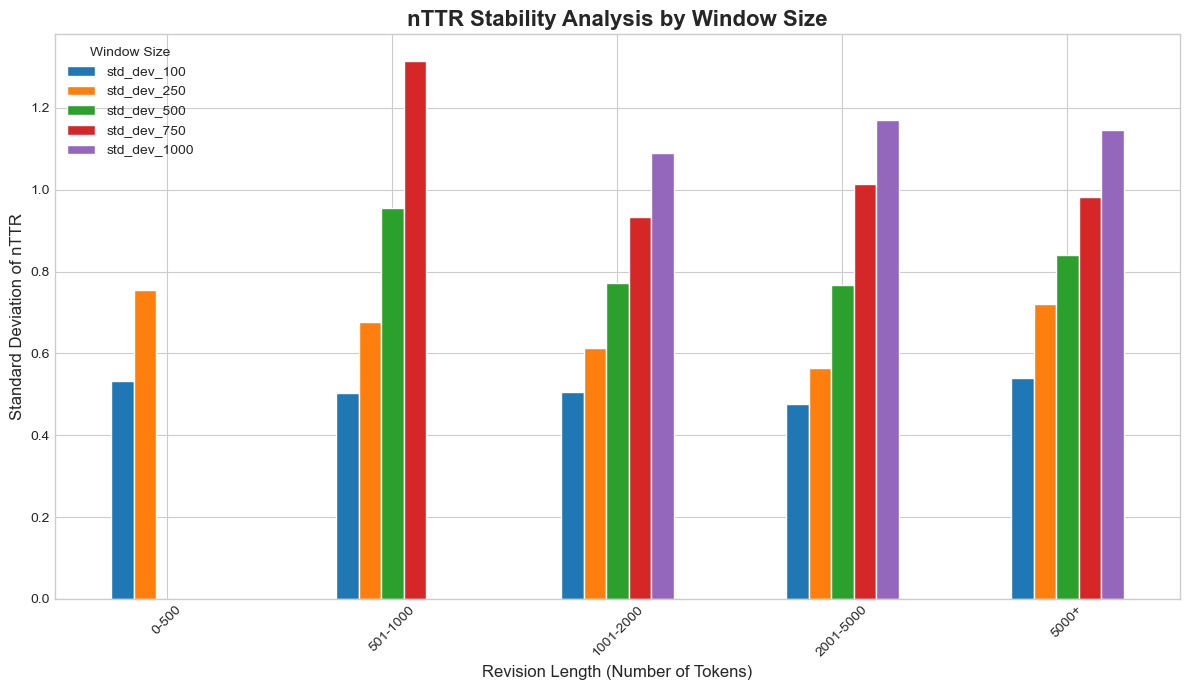

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the results
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

stability_df.plot(kind='bar', ax=ax)

ax.set_title('nTTR Stability Analysis by Window Size', fontsize=16, weight='bold')
ax.set_xlabel('Revision Length (Number of Tokens)', fontsize=12)
ax.set_ylabel('Standard Deviation of nTTR', fontsize=12)
ax.legend(title='Window Size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()